Importation des library

In [ ]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import anywidget
import os
plt.style.use('dark_background')

Chargement des données

In [ ]:
# Télécharger les données (Utilise Python Binance)
# a PARTIR D'une date jusqu'a aujourd'hui (intervale 15 minutes)
symbol = ['ETHUSDT']
#day
time = "5m"
# Téléchargement des données
data = vbt.BinanceData.download(
    symbol, 
    start='2025-11-01', 
    interval=time,
    tz_convert='Europe/Paris',
)

0it [00:00, ?it/s]

Mise en forme des données

In [ ]:
# Agencement des données + index + mis à l'heure de paris
df_raw = data.get(['Close','Open','High','Low','Volume']).copy()
df_raw.tail()

,Close,Open,High,Low,Volume
Open time,,,,,
2025-12-12 21:20:00+01:00,3076.89,3079.75,3079.76,3073.87,853.0717
2025-12-12 21:25:00+01:00,3071.80,3076.88,3076.89,3070.25,628.0167
2025-12-12 21:30:00+01:00,3072.21,3071.79,3075.36,3068.31,574.1623
2025-12-12 21:35:00+01:00,3072.15,3072.21,3073.58,3067.61,446.0294
2025-12-12 21:40:00+01:00,3078.00,3072.15,3079.41,3072.15,334.6517


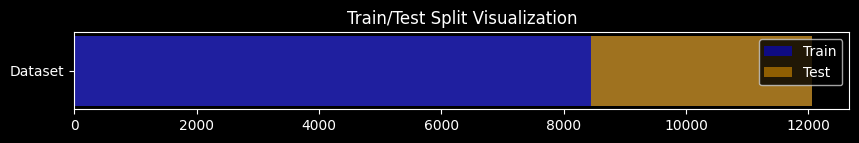

In [ ]:
# Separation des données en train et test (IS/OOS) (70/30%)
split_idx = int(0.7*len(df_raw))
train_data = df_raw.iloc[:split_idx]
test_data = df_raw.iloc[split_idx:]

# Affichage de la séparation des données
plt.figure(figsize=(10, 1))
plt.barh(['Dataset'], [len(df_raw)], color='lightgray', alpha=0.3)
plt.barh(['Dataset'], [split_idx], color='blue', alpha=0.5, label='Train')
plt.barh(['Dataset'], [len(df_raw)-split_idx], left=split_idx, color='orange', alpha=0.5, label='Test')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [ ]:
# Selection du train_set comme données d'entrainement
df = test_data.copy()

In [ ]:
import vectorbt as vbt
import pandas as pd
import plotly.graph_objects as go

close = df['Close']

# ================================================
# 1) Indicateurs EMA
# ================================================
ema21 = vbt.MA.run(close, window=21, ewm=True).ma
ema50 = vbt.MA.run(close, window=50, ewm=True).ma
ema200 = vbt.MA.run(close, window=200, ewm=True).ma   # non utilisée pour les signaux

# ================================================
# 2) Signaux basés UNIQUEMENT sur les croisements
# ================================================
entries = ema21.vbt.crossed_above(ema50)
exits   = ema21.vbt.crossed_below(ema50)

# ================================================
# 3) Backtest
# ================================================
pf = vbt.Portfolio.from_signals(
    close,
    entries,
    exits,
    init_cash=10_000,
    fees=0.0004,
    slippage=0.0002,
    freq='5m'
)

# ================================================
# 5) Résultats
# ================================================
print(pf.stats())

# ================================================
# 6) Chart : Candles + EMA + Signaux
# ================================================
fig = go.Figure()

# --- Bougies
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=close,
    name="Bougies",
    increasing_line_color='rgba(0,200,0,0.6)',
    decreasing_line_color='rgba(200,0,0,0.6)',
    increasing_fillcolor='rgba(0,200,0,0.3)',
    decreasing_fillcolor='rgba(200,0,0,0.3)'
))

# --- Moyennes mobiles exponentielles
fig.add_trace(go.Scatter(x=df.index, y=ema21, mode="lines", name="EMA 21", line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df.index, y=ema50, mode="lines", name="EMA 50", line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df.index, y=ema200, mode="lines", name="EMA 200", line=dict(color='red')))

# --- Signaux Entrées
fig.add_trace(go.Scatter(
    x=df.index[entries],
    y=close[entries],
    mode='markers',
    marker=dict(color='green', size=8),
    name='Buy'
))

# --- Signaux Sorties
fig.add_trace(go.Scatter(
    x=df.index[exits],
    y=close[exits],
    mode='markers',
    marker=dict(color='red', size=8),
    name='Sell'
))

# --- Paramètres graphiques
fig.update_layout(
    title="Stratégie EMA Cross — Bougies + Signaux",
    xaxis_title="Date",
    yaxis_title="Prix",
    xaxis_rangeslider_visible=False,
    template="plotly_dark",
    height=800
)

fig.show()
pf.plot().show()


Start                         2025-11-30 08:00:00+01:00
End                           2025-12-12 21:40:00+01:00
Period                                 12 days 13:45:00
Start Value                                     10000.0
End Value                                  10216.347488
Total Return [%]                               2.163475
Benchmark Return [%]                           2.618813
Max Gross Exposure [%]                            100.0
Total Fees Paid                              332.103592
Max Drawdown [%]                               11.88451
Max Drawdown Duration                   8 days 19:30:00
Total Trades                                         40
Total Closed Trades                                  40
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                       22.5
Best Trade [%]                                 6.107451
Worst Trade [%]                               -1